## Prerequisites

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

## Metadata

In [5]:
dataset_meta = ['pbmc_10k_v3']

cluster_names = ['Tcells','Monocytes','Bcells']
dataset_names = [x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [6]:
dataset_names

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [7]:
import loompy as lp
with lp.connect(loom_filepaths[0], mode="r") as ds:
    gene_names = ds.ra[gene_attr]


In [8]:
markers = ['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5',
      'CD93','CSTA','FPR1','CD14','CD36',
      'CD79A','CD22','BLK','IGHD','VPREB3']


In [9]:
markers_sep = [['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5'],
      ['CD93','CSTA','FPR1','CD14','CD36'],
      ['CD79A','CD22','BLK','IGHD','VPREB3']]


In [10]:
all([x in gene_names for x in markers])

True

## Filtering

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [12]:
cluster_annotations = []
for k in range(len(dataset_meta)):
    cluster_assignments = pd.read_csv(f'/home/ggorin/count_data/10x_metadata/{dataset_meta[k]}_analysis/analysis/clustering/kmeans_4_clusters/clusters.csv')
    print(cluster_assignments['Barcode'].str[-1:].unique())
    cluster_assignments['Barcode'] = cluster_assignments['Barcode'].str[:-2]
    cluster_annotations.append(cluster_assignments)

['1']


Dataset pbmc_10k_v3. 
	11756 barcodes in loom, 11171 pass filter. 11769 in annotations; of these, 11536 in loom and 11121 in filtered loom.
	Tcells: 5376 cells in annotations. 5375 in loom. 5339 pass filter.
	Monocytes: 3973 cells in annotations. 3972 in loom. 3933 pass filter.
	Bcells: 1650 cells in annotations. 1650 in loom. 1641 pass filter.


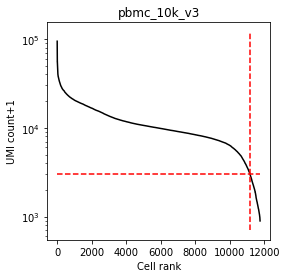

In [13]:
cf = []
thr_lb = [3e3]
fig1,ax1 = plt.subplots(1,1,figsize=(4,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k ]
    dataset_name = raw_data_locations[len(cluster_names)*k ]
    
    clusters = cluster_annotations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(clusters)
        annot_bcs_in_loom = clusters['Barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = clusters['Barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        for j,cluster in enumerate(cluster_names):
            annot_bcs = clusters[clusters['Cluster']==(j+1)]['Barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)


### v2/v3 comparison

In [14]:
[x.sum() for x in cf]


[5339, 3933, 1641]

## Preprocessing

In [15]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1 already exists.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:5339 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:4213 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells created.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:3933 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:4645 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes created.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:1641 cells detected.
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:2997 genes retained after expression filter.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_1

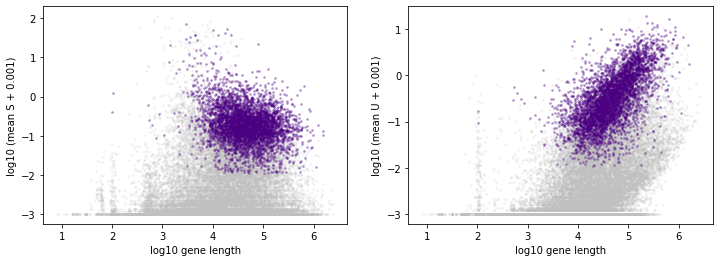

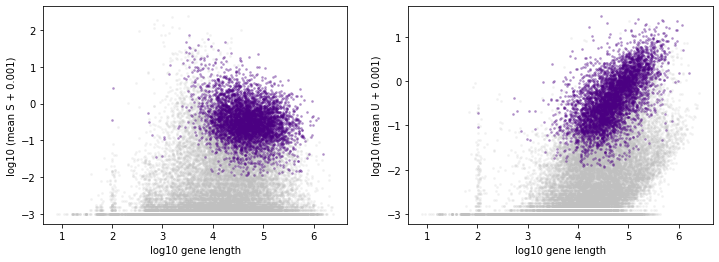

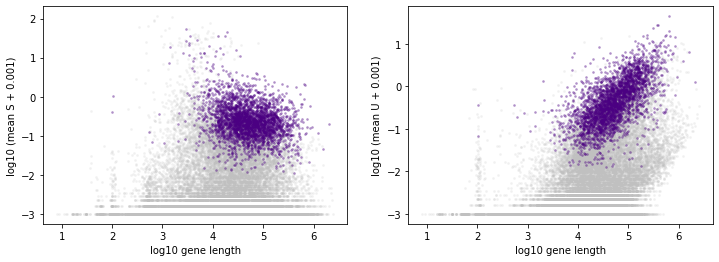

In [16]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='pbmc_celltypes',batch_id=1,\
                                             n_genes=3500,exp_filter_threshold=None,cf=cf,
                                             genes_to_fit=markers)

## Inference

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Tcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [2:13:17<00:00, 19.04s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 8008.6 seconds.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Monocytes
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:Starting parallelized grid sc

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:38:28<00:00, 14.07s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 5915.2 seconds.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21 created.
INFO:root:Global inference parameters stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: pbmc_10k_v3_Bcells
INFO:root:36601 features observed, 36169 match genome annotations. 35727 were unique.
INFO:root:Gene list extracted from ./fits/gg_221118_025_pbmc_celltypes_1/genes.csv.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 420/420 [1:20:51<00:00, 11.55s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures created.
INFO:root:Runtime: 4855.2 seconds.


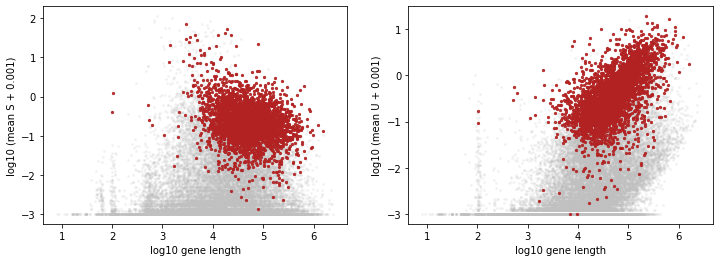

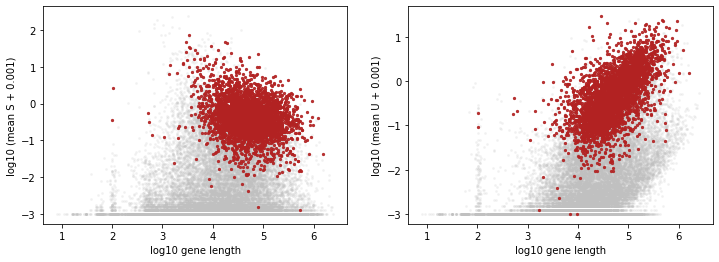

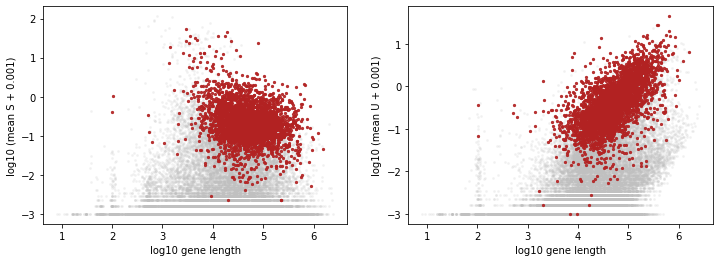

In [19]:
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [20,21]



result_strings = []
for i in range(n_datasets):
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(25,search_data)
    result_strings.append(full_result_string)


## Post-processing

In [20]:
dataset_names

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [21]:
dir_string

'./fits/gg_221118_025_pbmc_celltypes_1'

In [22]:
result_strings

['./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results.res',
 './fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results.res']

INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 43 genes out of 3500. Runtime: 13.8 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/subsampling.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/subsampling_stability.png.
INFO:root:Original optimum: -5.63, -

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 2994 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3171 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 133.6 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Tcells/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures created.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Monocytes/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/kldiv.png.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/gene_distributions_joint.png.
INFO:root:Chi-square computation

/home/ggorin/projects/monod/src/monod/inference.py:1354: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Gene 3447 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3458 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 3474 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 79.8 seconds.
INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/length_dependence.png.


/home/ggorin/projects/monod/src/monod/inference.py:1003: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(nrows=1, ncols=num_params, figsize=figsize)


INFO:root:Figure stored to ./fits/gg_221118_025_pbmc_celltypes_1/pbmc_10k_v3_Bcells/Bursty_Poisson_20x21/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_221118_025_pbmc_celltypes_1/analysis_figures already exists.


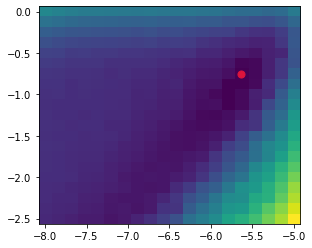

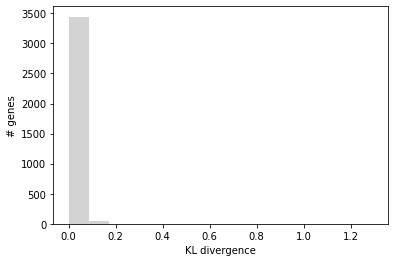

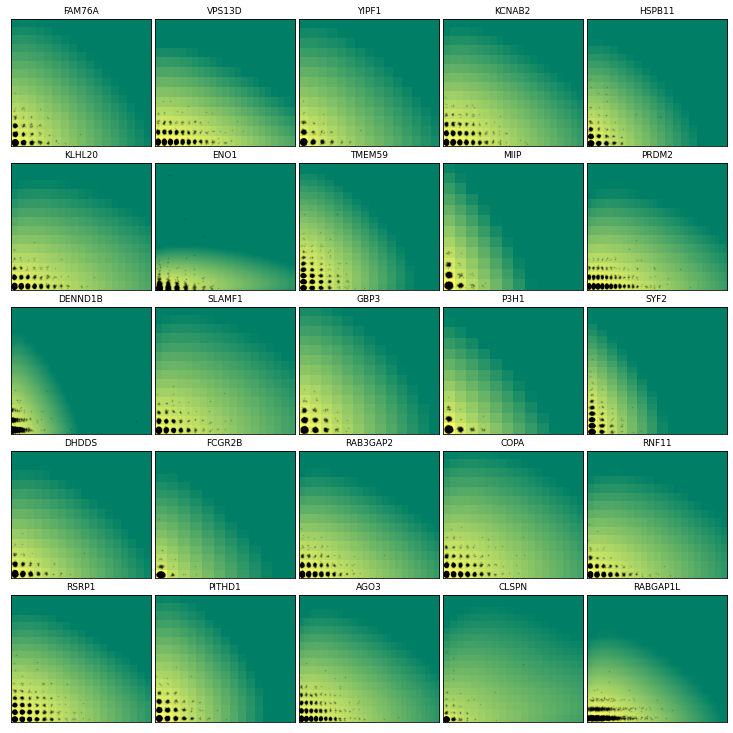

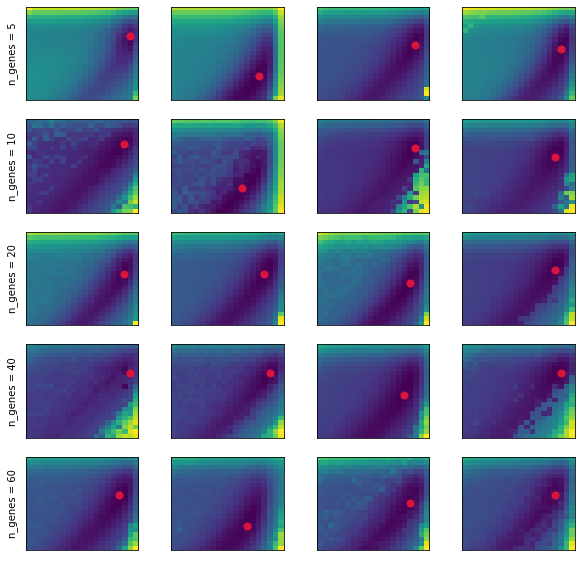

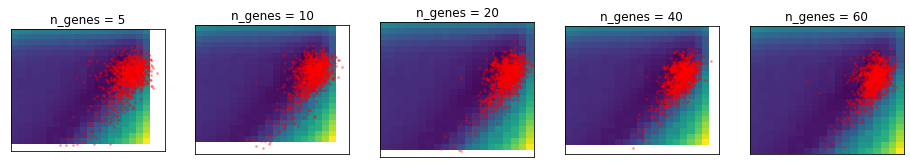

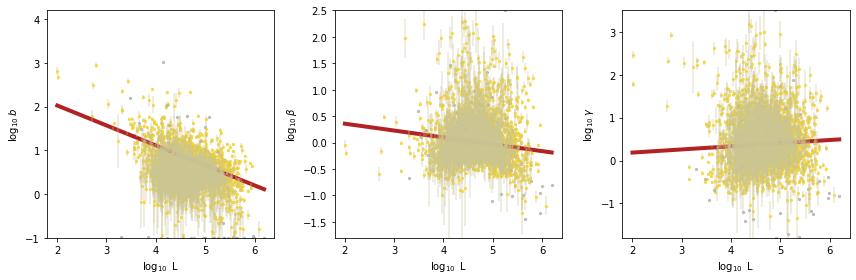

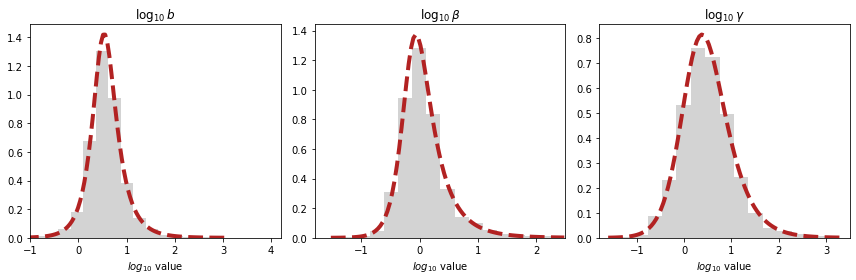

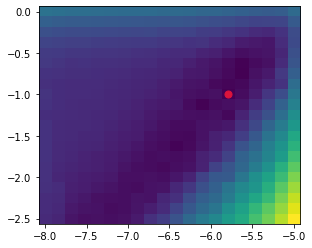

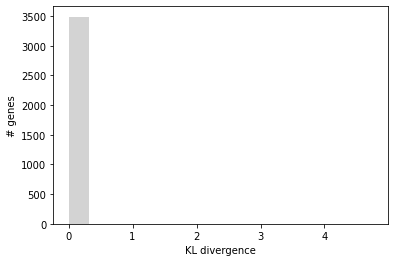

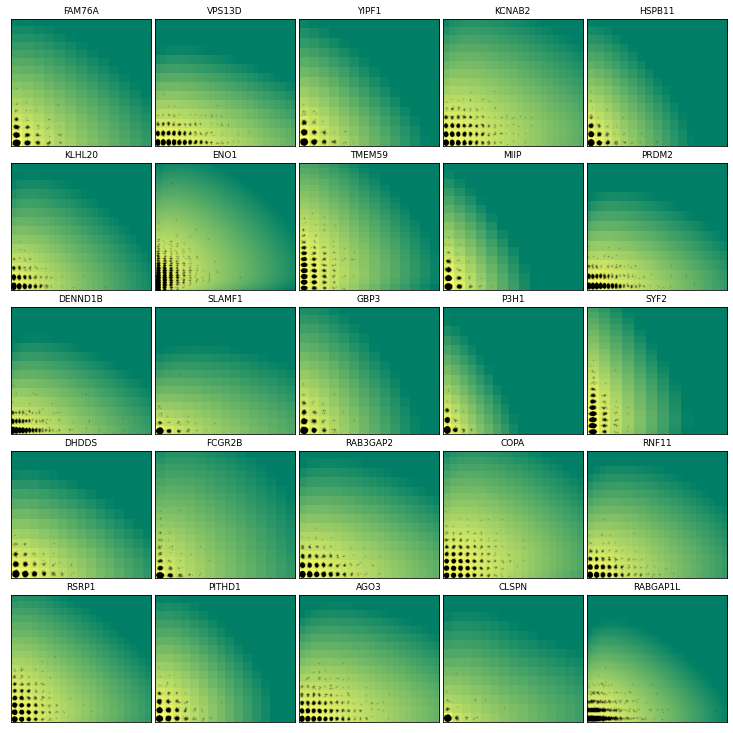

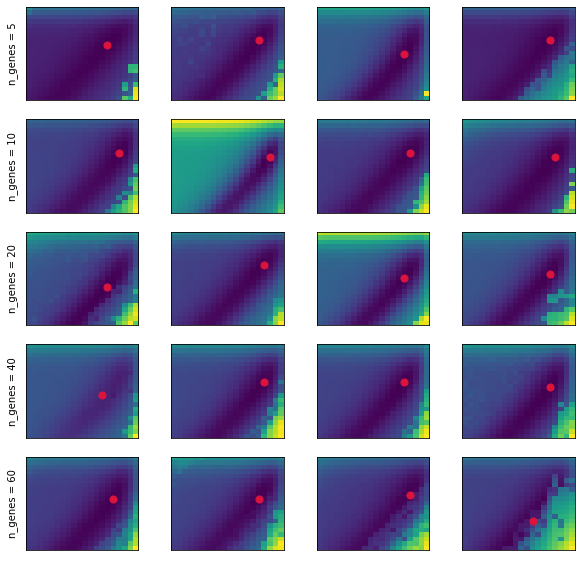

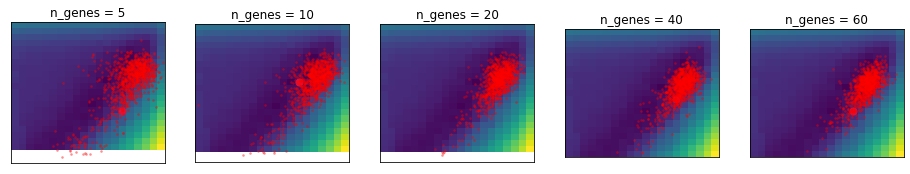

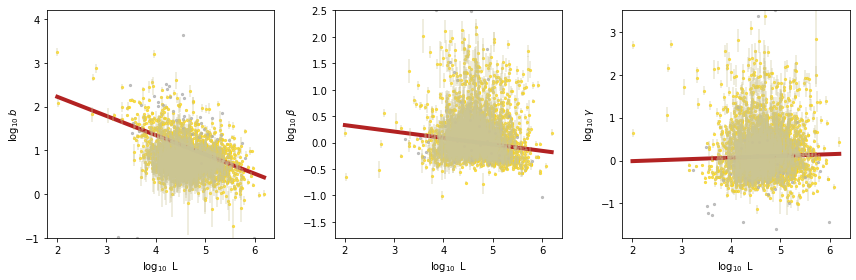

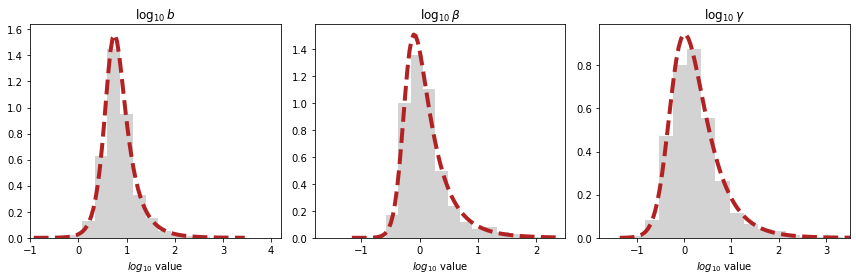

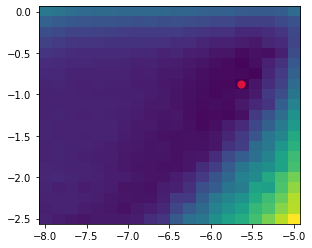

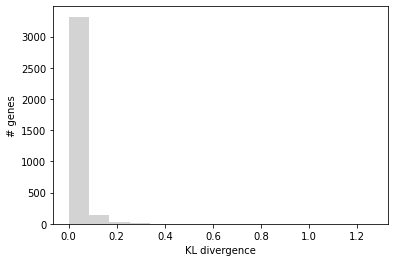

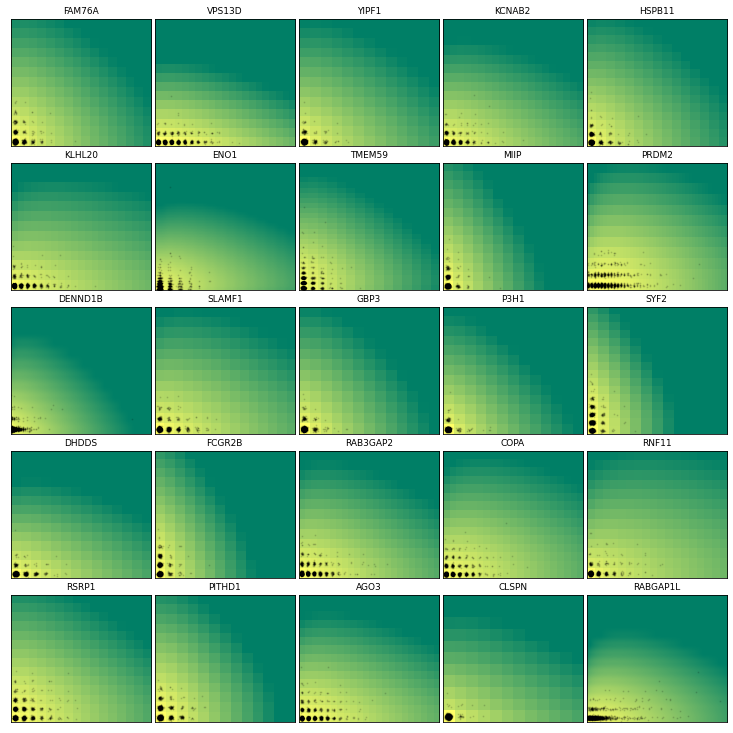

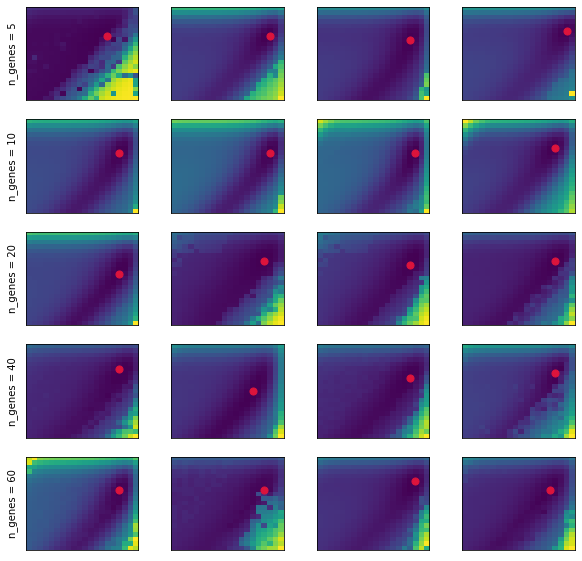

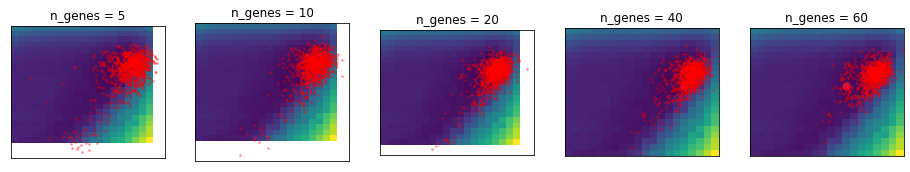

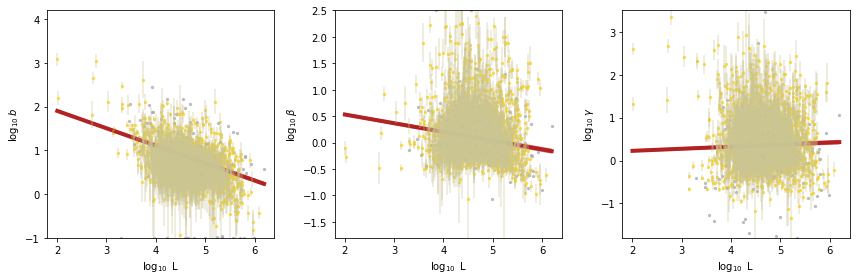

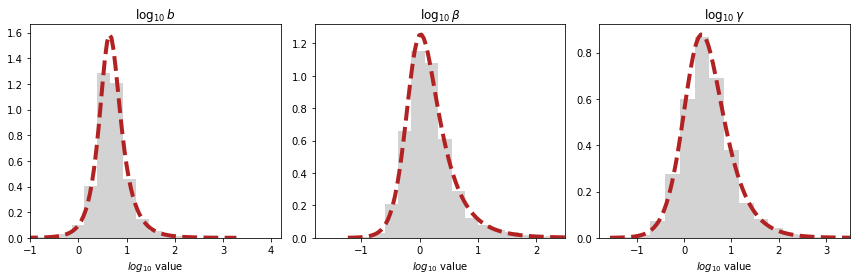

In [23]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

    sr.plot_gene_distributions(sd,marg='joint')

    _=sr.chisquare_testing(sd,threshold=0.01)
    sr.resample_opt_viz()
    sr.resample_opt_mc_viz()
    sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

    sr.compute_sigma(sd,num_cores=25)
    sr.plot_param_L_dep(plot_errorbars=True,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [63]:
# dir_string = './fits/gg_221108_025_pbmc_celltypes_4'
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [303]:
sr_arr = [ monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Tcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Monocytes/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v2_Bcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Tcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Monocytes/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_1k_v3_Bcells/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_221108_025_pbmc_celltypes_4/10x_pbmc_10k_v3_Tcells/Burst

## Analysis

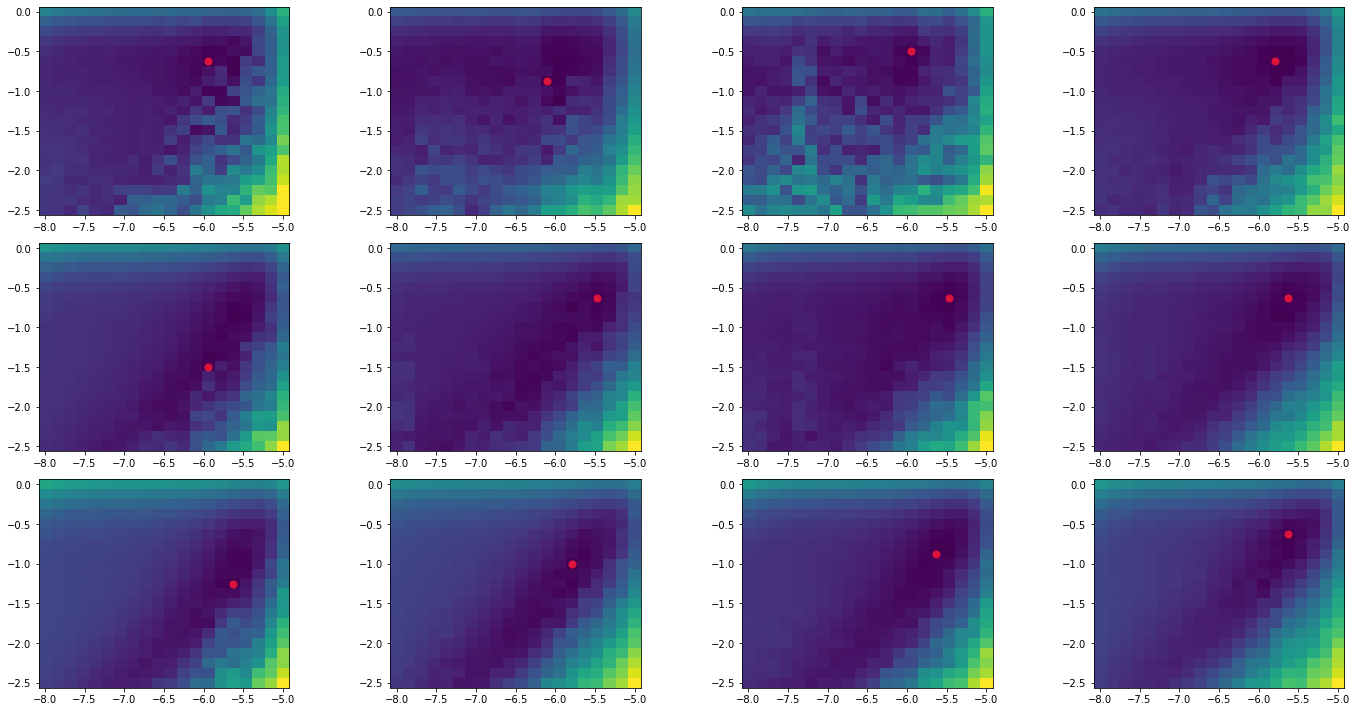

In [70]:
sz=(3,4)
fig1,ax1 = plt.subplots(sz[0],sz[1],figsize=(20,10))
for j,sr in enumerate(sr_arr):
    axloc = np.unravel_index(j,sz)
#     sr.find_sampling_optimum()  
#     sr.set_sampling_optimum(328)
    sr.plot_landscape(ax1[axloc],discard_rejected=True)
#     monod.analysis.make_batch_analysis_dir([sr],dir_string)
#     _=sr.chisquare_testing(sd_arr[j],threshold=1e-6)
fig1.tight_layout()

In [71]:
opt = []
opt_region = []
n_cells = []
for i in range(n_datasets):
#     sr = monod.analysis.load_search_results(result_strings[i])
    opt.append(sr_arr[i].samp_optimum)
    n_cells.append(sr_arr[i].n_cells)
    q = np.quantile(sr_arr[i].obj_func,0.1)
    opt_region.append(np.asarray(sr_arr[i].sp.sampl_vals)[sr_arr[i].obj_func<q])
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [74]:
n_cells

array([  572,   328,    79,   979,   552,   363,   193,  1108,  5339,
        3933,  1641, 10913])

(-2.6, 0.1)

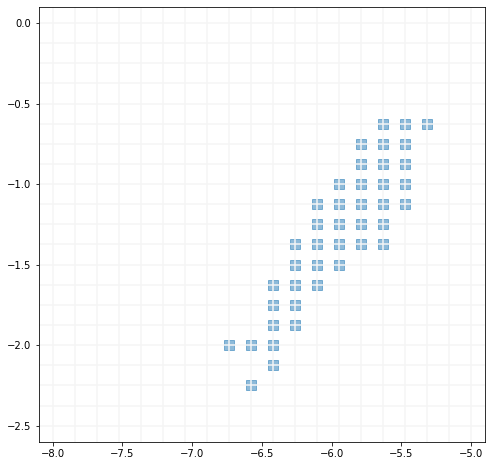

In [72]:
fs = 20

sr = sr_arr[0]
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])


d=0.1
fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')

j = 4
plt.scatter(opt_region[j][:,0],opt_region[j][:,1],100,marker='s',alpha=0.5)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])



In [80]:
import matplotlib

Text(0, 0.5, '$\\log_{10} \\lambda_M$')

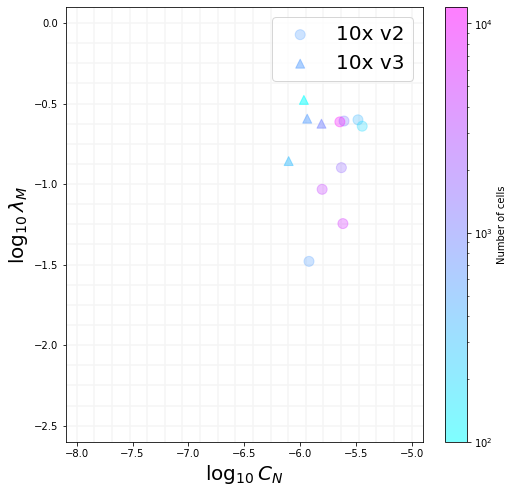

In [83]:
fs = 20

sr = sr_arr[0]
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])


d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.02
opt_ = opt+jit
cmap = 'cool'

ctf = range(4,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],100,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='10x v2',norm=matplotlib.colors.LogNorm(vmin=100,vmax=12000))
stf = range(4)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='10x v3',norm=matplotlib.colors.LogNorm(vmin=100,vmax=12000))
# ctf = range(4,n_datasets)
# plt.scatter(opt_[ctf,0],opt_[ctf,1],100,n_cells[ctf],zorder=1000,
#             alpha=0.3,cmap=cmap,label='10x v2',vmin=0,vmax=12000,norm=matplotlib.colors.LogNorm())
# stf = range(4)
# plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
#             alpha=0.5,cmap=cmap,label='10x v3',vmin=0,vmax=12000,norm=matplotlib.colors.LogNorm())
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

# fig_string = sr.batch_analysis_string+'/landscape_qc.png'
# plt.savefig(fig_string,dpi=450)


In [89]:
search_data = sd_arr[j]

In [90]:
csqarr = []


In [93]:
hist_type = monod.inference.get_hist_type(search_data)

In [94]:
hist_type

'unique'

In [116]:
observed[b_]


15.999999999999996

In [117]:
(counts[bins==b_].sum())

15.999999999999996

In [ ]:
sr_arr[5].sam

In [30]:
sr_arr[2].set_sampling_optimum(328)

(-5.631578947368421, -0.875)

In [28]:
sr_arr[5].samp_optimum_ind

328

In [42]:
# thr=1e-12
# _=sr_arr[0].chisquare_testing(sd_arr[0],threshold=thr)
# _=sr_arr[3].chisquare_testing(sd_arr[3],threshold=thr)

INFO:root:Chi-square computation complete. Rejected 107 genes out of 3000. Runtime: 6.0 seconds.
INFO:root:Chi-square computation complete. Rejected 901 genes out of 3000. Runtime: 9.7 seconds.


### T-cells

In [84]:
dataset_names

['10x_pbmc_1k_v2_Tcells',
 '10x_pbmc_1k_v2_Monocytes',
 '10x_pbmc_1k_v2_Bcells',
 '10x_pbmc_1k_v2_All',
 '10x_pbmc_1k_v3_Tcells',
 '10x_pbmc_1k_v3_Monocytes',
 '10x_pbmc_1k_v3_Bcells',
 '10x_pbmc_1k_v3_All',
 '10x_pbmc_10k_v3_Tcells',
 '10x_pbmc_10k_v3_Monocytes',
 '10x_pbmc_10k_v3_Bcells',
 '10x_pbmc_10k_v3_All']

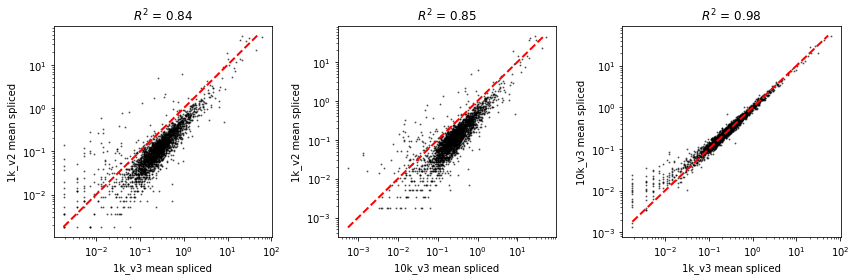

In [90]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4].layers[1]
    y = sd_arr[k2*4].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/3430383092.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/3430383092.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


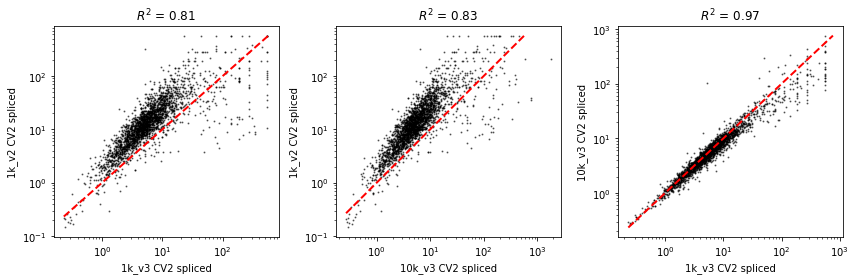

In [91]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4].layers[1]
    y = sd_arr[k2*4].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [92]:
sr_arr[0].samp_optimum

(-5.947368421052632, -0.625)

In [352]:
sr_arr[6].samp_optimum

(-5.473684210526316, -0.75)

In [353]:
sr_arr[0].samp_optimum_ind

246

In [354]:
sr_arr[6].samp_optimum_ind

350

In [355]:
sr_arr[0].set_sampling_optimum(np.argmin(((sr_arr[0].param_estimates[:,~sr_arr[6].rejected_genes,:] - sr_arr[6].phys_optimum[~sr_arr[6].rejected_genes])**2).sum((1,2))))
sr_arr[0].chisquare_testing(sd_arr[0],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 183 genes out of 2500. Runtime: 2.7 seconds.


(array([11.55801876,  5.6916193 ,  5.08663127, ..., 15.0972433 ,
        17.47350333,  4.6791198 ]),
 array([0.00906125, 0.22339238, 0.02411098, ..., 0.08829927, 0.06452144,
        0.09637004]))

In [356]:
sr_arr[0].samp_optimum

(-5.631578947368421, -0.875)

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


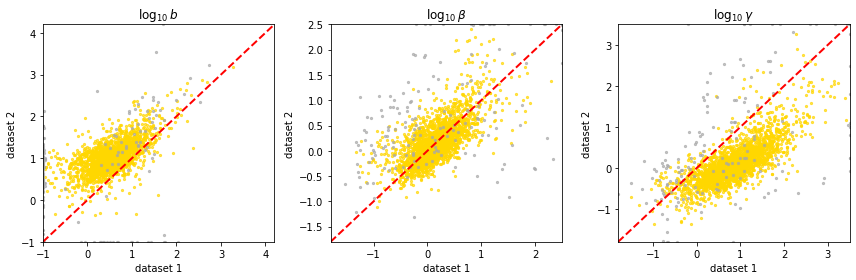

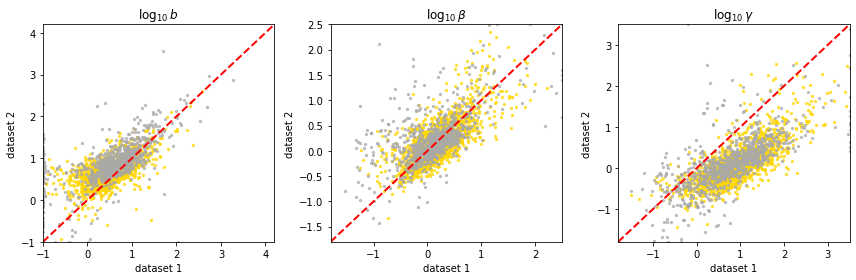

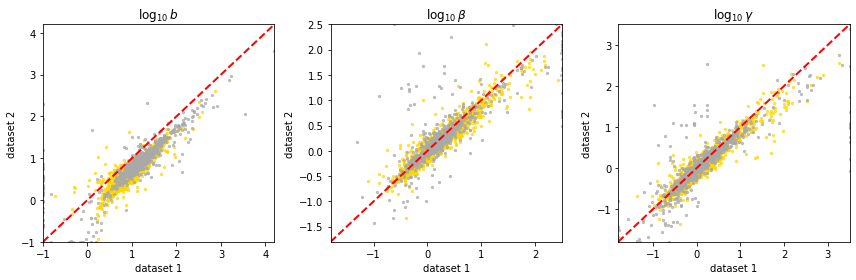

In [93]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[4])
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[8])
monod.analysis.plot_params_for_pair(sr_arr[4],sr_arr[8])


### Monocytes

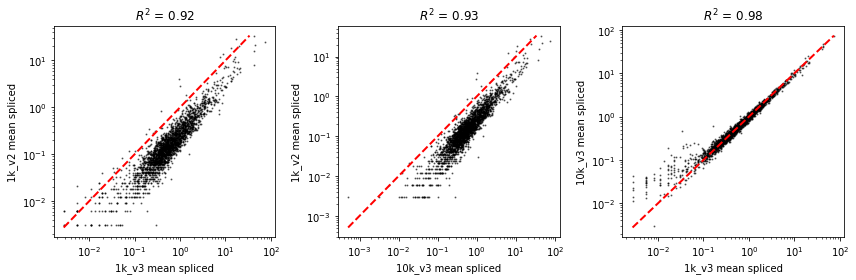

In [94]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+1].layers[1]
    y = sd_arr[k2*4+1].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/1969919893.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/1969919893.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


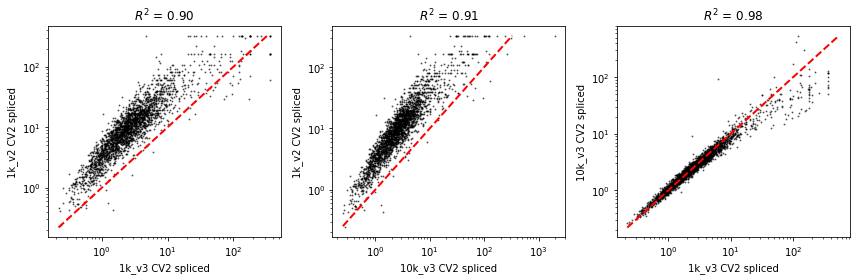

In [95]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+1].layers[1]
    y = sd_arr[k2*4+1].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [232]:
sr_arr[1].set_sampling_optimum(np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[7].rejected_genes,:] - sr_arr[7].phys_optimum[~sr_arr[7].rejected_genes])**2).sum((1,2))))
sr_arr[1].chisquare_testing(sd_arr[1],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 108 genes out of 2500. Runtime: 2.6 seconds.


(array([ 0.70215438,  4.7959536 ,  0.27308779, ..., 14.55792608,
         0.85583671,  1.60059856]),
 array([0.70392942, 0.18736285,        nan, ..., 0.02398827, 0.35490639,
               nan]))

In [233]:
sr_arr[1].samp_optimum_ind

262

In [234]:
sr_arr[7].samp_optimum_ind

284

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


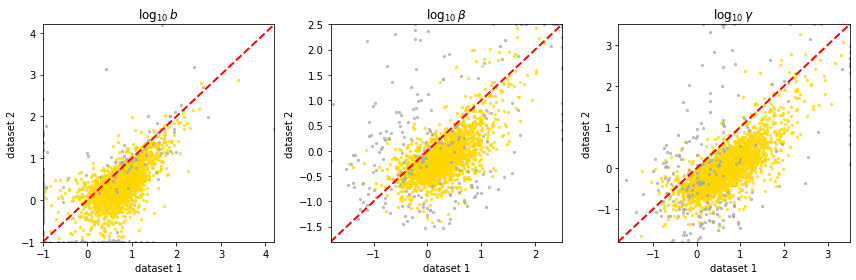

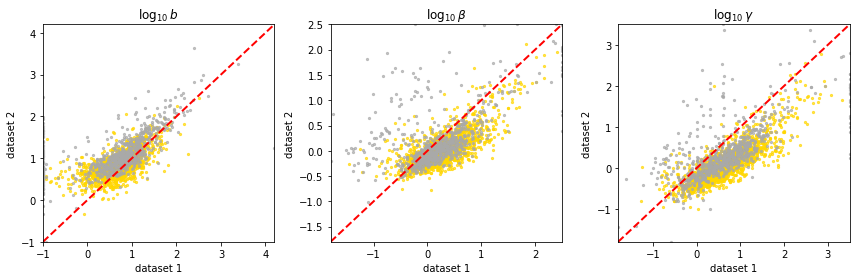

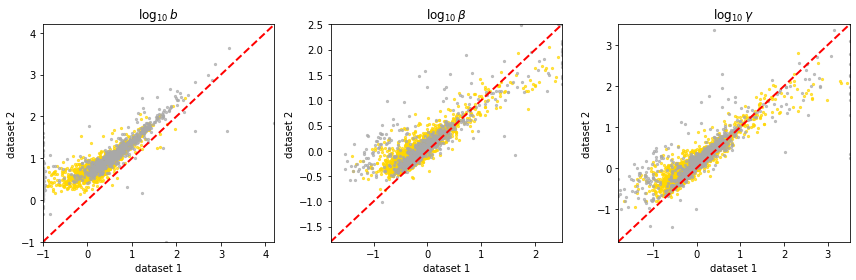

In [96]:
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[5])
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[9])
monod.analysis.plot_params_for_pair(sr_arr[5],sr_arr[9])


### B cells

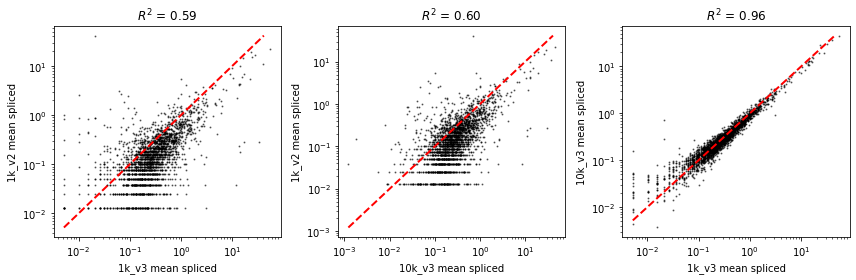

In [97]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+2].layers[1]
    y = sd_arr[k2*4+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

/tmp/ipykernel_1595883/3717370790.py:11: RuntimeWarning: invalid value encountered in divide
  x = x.var(1)/(x.mean(1)**2)
/tmp/ipykernel_1595883/3717370790.py:12: RuntimeWarning: invalid value encountered in divide
  y = y.var(1)/(y.mean(1)**2)


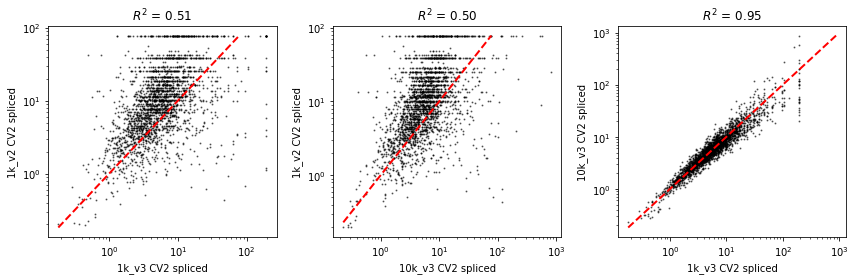

In [98]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*4+2].layers[1]
    y = sd_arr[k2*4+2].layers[1]
    x = x.var(1)/(x.mean(1)**2)
    y = y.var(1)/(y.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' CV2 spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' CV2 spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [238]:
sr_arr[2].set_sampling_optimum(np.argmin(((sr_arr[2].param_estimates[:,~sr_arr[8].rejected_genes,:] - sr_arr[8].phys_optimum[~sr_arr[8].rejected_genes])**2).sum((1,2))))
sr_arr[2].chisquare_testing(sd_arr[2],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 515 genes out of 2500. Runtime: 2.3 seconds.


(array([1.62626891e-01, 6.15881860e-01, 1.57531340e-01, ...,
        2.11040085e+01, 1.08199339e+00, 2.72776318e-06]),
 array([       nan,        nan,        nan, ..., 0.00030198, 0.29825205,
               nan]))

In [267]:
search_data

In [268]:
sr = sr_arr[2]
search_data = sd_arr[2]
sd = sd_arr[2]

In [269]:
csqarr = []
hist_type = monod.inference.get_hist_type(sd)
for gene_index in range(sr.n_genes):
    lm = search_data.M[:, gene_index]
    expect_freq = sr.model.eval_model_pss(
        sr.phys_optimum[gene_index], lm, sr.regressor_optimum[gene_index] 
    ) * search_data.n_cells

    if hist_type == "grid":
        raise ValueError('Not implemented in current version.')
    elif hist_type == "unique":
        counts = np.concatenate(
            (search_data.n_cells * search_data.hist[gene_index][1], [0])
        )
        expect_freq = expect_freq[
            search_data.hist[gene_index][0][:, 0],
            search_data.hist[gene_index][0][:, 1],
        ]
        expect_freq = np.concatenate(
            (expect_freq, [search_data.n_cells - expect_freq.sum()])
        )

    bins = []
    bin_ind = 0
    run_bin_obs = 0
    run_bin_exp = 0
    bin_obs = []
    bin_exp = []
    for i in range(len(counts)):
        bins.append(bin_ind)
        run_bin_obs += counts[i]
        run_bin_exp += expect_freq[i]
        if min(run_bin_obs,run_bin_exp) < 5:# and i
            pass
        else:
            bin_ind += 1
            bin_obs.append(run_bin_obs)
            bin_exp.append(run_bin_exp)
            run_bin_obs = 0
            run_bin_exp = 0
    bins=np.asarray(bins)
    observed = np.asarray(bin_obs)
    proposed = np.asarray(bin_exp)
    observed[-1] += run_bin_obs
    proposed[-1] += run_bin_exp
    bins[bins==len(observed)] = len(observed)-1

    for b_ in range(len(bin_obs)): 
        assert np.isclose(observed[b_],counts[bins==b_].sum())
        assert np.isclose(proposed[b_],expect_freq[bins==b_].sum())
    assert np.isclose(observed.sum(),search_data.n_cells)
    assert np.isclose(proposed.sum(),search_data.n_cells)
    assert np.isclose(search_data.n_cells,counts.sum())
    assert np.isclose(search_data.n_cells,expect_freq.sum())
    csqarr += [
        scipy.stats.mstats.chisquare(
            observed, proposed,#chisq_data, chisq_prop, 
            sr.model.get_num_params()
        )
    ]


In [281]:
counts

array([71.,  1.,  5.,  1.,  1.,  0.])

In [283]:
expect_freq

array([70.99557034,  0.55825023,  5.36999185,  1.20185915,  0.31704972,
        0.55727871])

In [286]:
scipy.stats.mstats.chisquare(
            observed, proposed,0)

Power_divergenceResult(statistic=2.727763180210029e-06, pvalue=0.9986822191396537)

In [275]:
observed

array([71.,  8.])

In [270]:
bonferroni = True
threshold = 1e-6
reject_at_bounds=True
bound_thr = 1e-2
csq, pval = zip(*csqarr)
csq = np.asarray(csq)
pval = np.asarray(pval)

if bonferroni:
    threshold /= sr.n_genes
rejected_genes = pval < threshold

if reject_at_bounds:
    bound_range = sr.sp.phys_ub - sr.sp.phys_lb
    lb = sr.sp.phys_lb + bound_range * bound_thr
    ub = sr.sp.phys_ub - bound_range * bound_thr

    rej_poor_fit = ((sr.phys_optimum < lb) | (sr.phys_optimum > ub)).any(1)
    rejected_genes = (rejected_genes) | rej_poor_fit


In [273]:
pval

array([       nan,        nan,        nan, ..., 0.00030198, 0.29825205,
              nan])

In [272]:
sr.rejected_genes.sum()

515

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


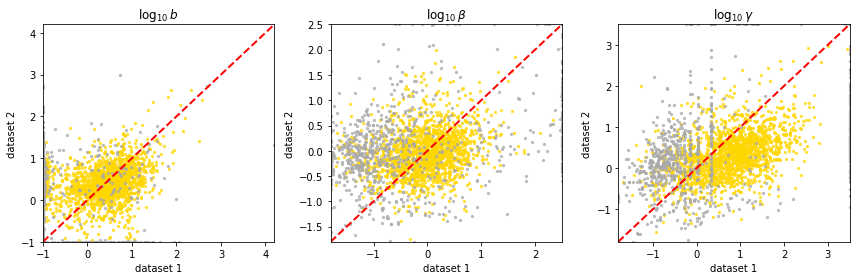

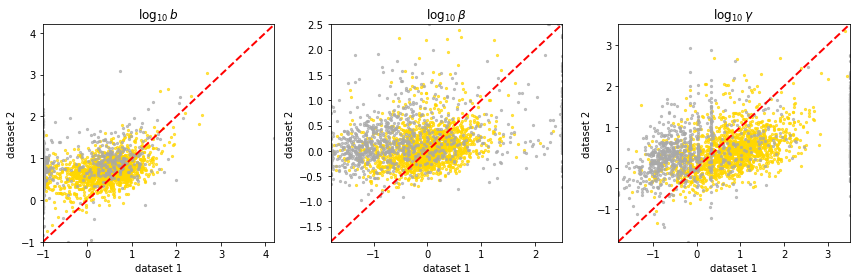

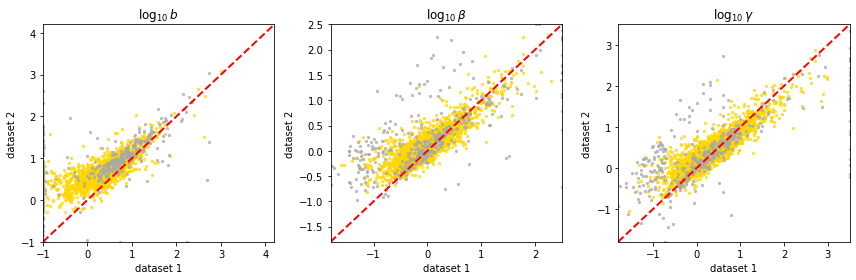

In [99]:
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[6])
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[10])
monod.analysis.plot_params_for_pair(sr_arr[6],sr_arr[10])


### All

In [101]:
sr_arr[3].samp_optimum

(-5.7894736842105265, -0.625)

In [102]:
sr_arr[7].samp_optimum

(-5.631578947368421, -0.625)

In [103]:
sr_arr[11].samp_optimum

(-5.631578947368421, -0.625)

In [112]:
np.argmin((np.abs(sr_arr[3].param_estimates[:,~sr_arr[11].rejected_genes,:] - sr_arr[11].phys_optimum[~sr_arr[11].rejected_genes])).sum((1,2)))

285

In [106]:
sr_arr[3].samp_optimum_ind

309

In [109]:
sr_arr[3].set_sampling_optimum(285)
_=sr_arr[3].chisquare_testing(sd_arr[3],threshold=1e-6)

INFO:root:Chi-square computation complete. Rejected 62 genes out of 2500. Runtime: 3.1 seconds.


In [111]:
sr_arr[3].samp_optimum

(-5.947368421052632, -1.0)

INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.
INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


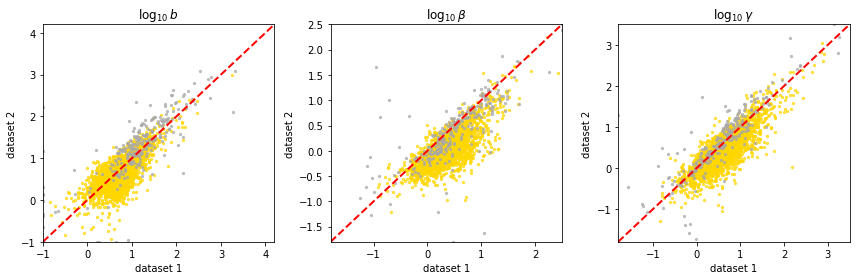

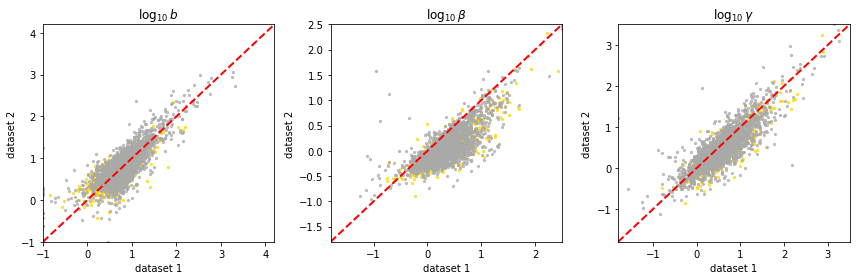

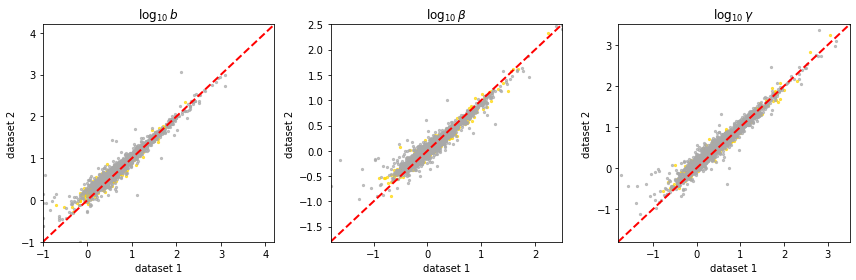

In [110]:
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[7])
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[11])
monod.analysis.plot_params_for_pair(sr_arr[7],sr_arr[11])


### Controls

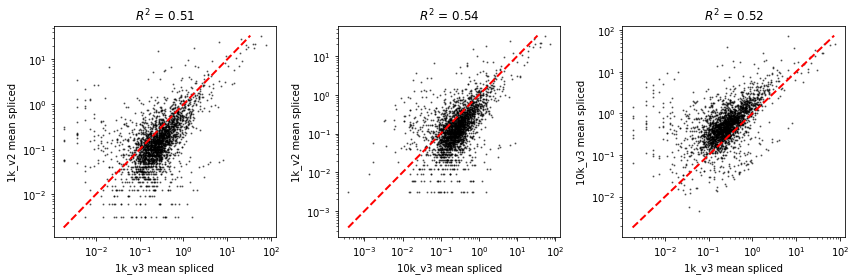

In [295]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3].layers[1]
    y = sd_arr[k2*3+1].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

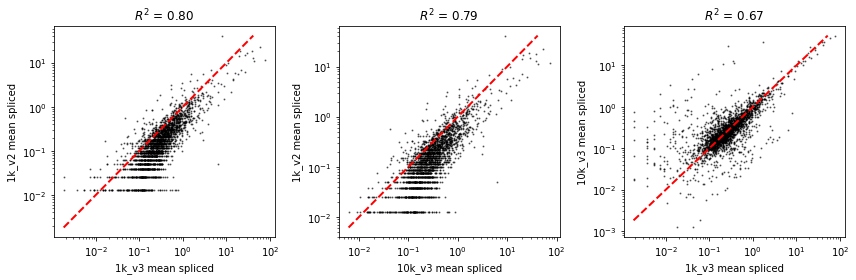

In [296]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3].layers[1]
    y = sd_arr[k2*3+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

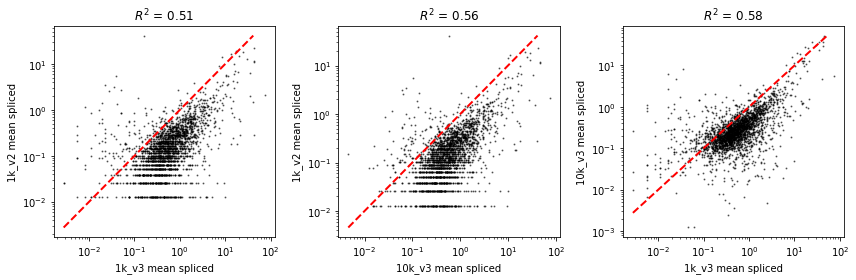

In [297]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[1,0],[2,0],[1,2]]


for q,pair in enumerate(pairs):
    k1 = pair[0]
    k2 = pair[1]

    x = sd_arr[k1*3+1].layers[1]
    y = sd_arr[k2*3+2].layers[1]
    x = x.mean(1)
    y = y.mean(1)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1[q].scatter(x,y,1,'k',alpha=0.5)
    ax1[q].set_xscale('log')
    ax1[q].set_yscale('log')
    ax1[q].set_xlabel(dataset_meta[k1]+' mean spliced')
    ax1[q].set_ylabel(dataset_meta[k2]+' mean spliced')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(np.log10(x),np.log10(y))[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    ax1[q].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()

In [25]:
df = np.abs(sr_arr[3].phys_optimum-sr_arr[4].phys_optimum)

In [16]:
top_genes = np.argsort(df,0)[:50]

In [17]:
sr_arr[3].gene_names[top_genes]

array([['CAMTA1', 'ANP32E', 'BLK'],
       ['FEZ2', 'DNAJC21', 'DIAPH1'],
       ['CBX1', 'FGFR1OP2', 'GIGYF1'],
       ['HMCES', 'RBM27', 'SP110'],
       ['UHRF1', 'ID2', 'PARP14'],
       ['SYNRG', 'ARGLU1', 'NPM1'],
       ['ITGAX', 'ALG5', 'MESD'],
       ['PDS5B', 'ITGB3BP', 'PCM1'],
       ['CABIN1', 'RC3H2', 'PKN1'],
       ['CD46', 'MESD', 'PLEKHA3'],
       ['RPL41', 'CNOT7', 'ARID1B'],
       ['CD69', 'ZFR', 'RPL24'],
       ['PRPS1', 'PUM1', 'CAPZB'],
       ['MAPRE2', 'PIAS1', 'RAP1GDS1'],
       ['ZRSR2', 'RAP2A', 'TBL1XR1'],
       ['NELL2', 'EIF3A', 'LNPEP'],
       ['MLXIP', 'TMEM50A', 'PMPCB'],
       ['SAMD8', 'TMEM131', 'BTN3A2'],
       ['LRPPRC', 'CEBPZ', 'BMS1'],
       ['ELOVL5', 'NCOA2', 'CLSTN1'],
       ['TPR', 'AKAP13', 'SYAP1'],
       ['SKAP2', 'AMD1', 'SLC35C2'],
       ['MRPS35', 'ERBIN', 'SFPQ'],
       ['APC', 'RNASET2', 'NDUFS5'],
       ['EIF2B1', 'MICU2', 'HSP90AB1'],
       ['RP2', 'GATAD2A', 'TMEM123'],
       ['THOC2', 'SFSWAP', 'UVRAG'],
       

In [18]:
np.where(sr_arr[3].gene_names=='CD4')

(array([527]),)

In [19]:
gi = 629
gi = np.where(sd_arr[0].gene_names=='CD69')
gi = np.where(sd_arr[0].gene_names=='CD36')

In [20]:
sd_arr[3].layers[1,gi].mean()

0.03596179059749017

In [21]:
sd_arr[4].layers[1,gi].mean()

4.354691075514874

In [90]:
'CD36' in sd_arr[0].gene_names

True

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


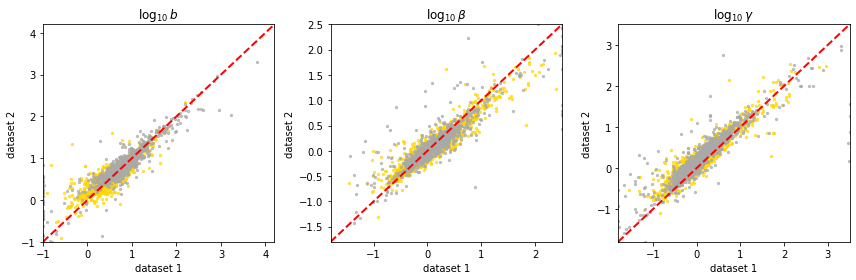

In [26]:
monod.analysis.plot_params_for_pair(sr_arr[0],sr_arr[3])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


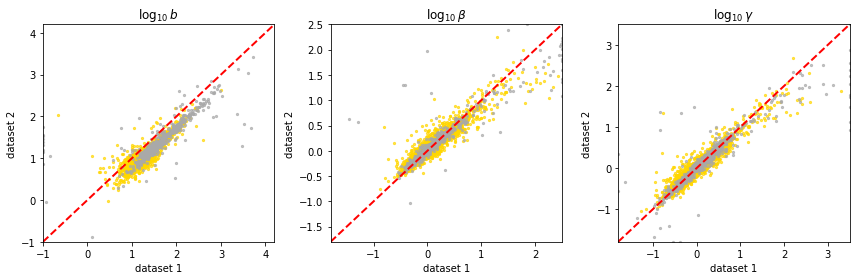

In [27]:
monod.analysis.plot_params_for_pair(sr_arr[1],sr_arr[4])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/analysis_figures/pair_parameter_comparison_12.png.


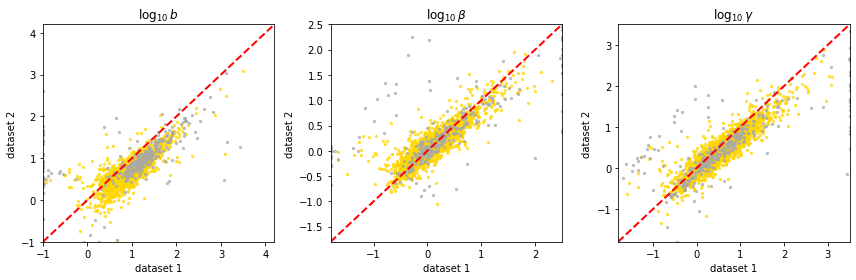

In [28]:
monod.analysis.plot_params_for_pair(sr_arr[2],sr_arr[5])

In [29]:
[x.sum() for x in cf]

[552, 363, 193, 5339, 3933, 1641]

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_2/analysis_figures/parameter_residuals_10k.png.


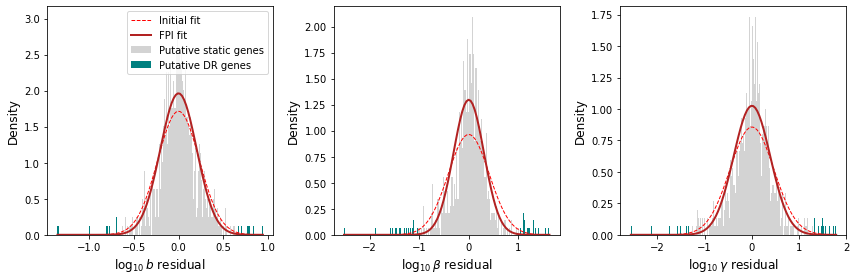

In [22]:
dr_analysis = []
# for j in range(2):
dr_analysis.append(monod.analysis.diffexp_pars(sr_arr[3],sr_arr[4],viz=True,modeltype='id',
                                   meta=dataset_meta[1],use_sigma=False,pval_thr=0.001,nit=20))


In [28]:
dr_analysis[0][-4]

[array(['THEMIS2', 'ITGB1', 'SPI1', 'OSBPL5', 'PRCP', 'CLECL1', 'NCOR2',
        'NAGK', 'CSF2RB', 'TTC38', 'CD38', 'GFOD1', 'CYBB'], dtype='<U17'),
 array(['SLAMF1', 'FCMR', 'PYHIN1', 'ATP8B2', 'DHRS3', 'PRKCQ-AS1', 'SPI1',
        'ETS1', 'CLEC4A', 'EVL', 'RASGRP1', 'ITGAX', 'CBFA2T3', 'CCR7',
        'TNRC6C', 'KYNU', 'ZAP70', 'SESTD1', 'NFATC2', 'CSF2RB', 'SEL1L3',
        'TBC1D9', 'TCF7', 'LY86', 'FGD2', 'SH2B2', 'TRIB1', 'SYK', 'CYBB',
        'CXorf21'], dtype='<U17'),
 array(['FCMR', 'PYHIN1', 'ATP8B2', 'PRKCQ-AS1', 'ETS1', 'CLEC4A', 'ALDH2',
        'RASGRP1', 'CBFA2T3', 'CCR7', 'ZAP70', 'NFATC2', 'PRR5', 'CSF2RB',
        'TBC1D9', 'TCF7', 'TRIB1', 'SYK'], dtype='<U17')]

In [31]:
markers_sep

[['CD3D',
  'CD3G',
  'CD3E',
  'CD247',
  'CD2',
  'TCF7',
  'CD4',
  'CCL5',
  'CD69',
  'CCL5'],
 ['CD93', 'CSTA', 'FPR1', 'CD14', 'CD36'],
 ['CD79A', 'CD22', 'BLK', 'IGHD', 'VPREB3']]

In [57]:
gf_rej = (~sr_arr[3].rejected_genes) & (~sr_arr[5].rejected_genes)
fc_par = (sr_arr[5].phys_optimum-sr_arr[3].phys_optimum)/np.log10(2)
# gf_rej = (~sr_arr[3].rejected_genes) & (~sr_arr[4].rejected_genes)
# fc_par = (sr_arr[4].phys_optimum-sr_arr[3].phys_optimum)/np.log10(2)

gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[0]]
gf_mark_t = np.zeros(n_genes,dtype=bool)
gf_mark_t[gf_mark_] = True

# gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[1]]
# gf_mark_mono = np.zeros(n_genes,dtype=bool)
# gf_mark_mono[gf_mark_] = True

gf_mark_ = [np.where(gn == x)[0][0] for x in markers_sep[2]]
gf_mark_b = np.zeros(n_genes,dtype=bool)
gf_mark_b[gf_mark_] = True

In [59]:
(sr_arr[5].rejected_genes).sum()

288

In [42]:
# gf_mark.sum()

<>:35: DeprecationWarning: invalid escape sequence \l
<>:36: DeprecationWarning: invalid escape sequence \l
<>:35: DeprecationWarning: invalid escape sequence \l
<>:36: DeprecationWarning: invalid escape sequence \l
/tmp/ipykernel_1595883/2387342294.py:35: DeprecationWarning: invalid escape sequence \l
  ax1[q].set_xlabel(raw_param_names[k1]+' $\log_2$ fold change')
/tmp/ipykernel_1595883/2387342294.py:36: DeprecationWarning: invalid escape sequence \l
  ax1[q].set_ylabel(raw_param_names[k2]+' $\log_2$ fold change')


NameError: name 'fc_par' is not defined

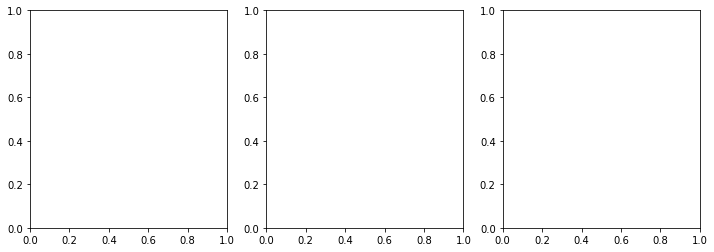

In [87]:
q=0

raw_param_names = (r'$b$',r'$\beta/k$',r'$\gamma/k$')

n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
pval_thr = 0.1/n_genes
param_names = sr_arr[0].model.get_log_name_str()
gn = sr_arr[0].gene_names
fs = 12



fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
pairs = [[0,1],[0,2],[1,2]]

q=0
for pair in pairs:
    k1 = pair[0]
    k2 = pair[1]
#     gf = 

    x = fc_par[:,k1]
    y = fc_par[:,k2]
#     x[np.isnan(x)] = 0 
#     y[np.isnan(y)] = 0

#     ax1[q].scatter(x[~gf],y[~gf],4,'darkgray',alpha=0.4)
#     ax1[q].scatter(x,y,4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf_rej],y[gf_rej],4,'darkgray',alpha=0.4)
    ax1[q].scatter(x[gf_mark_t],y[gf_mark_t],50,'orange',alpha=0.4)
    ax1[q].scatter(x[gf_mark_b],y[gf_mark_b],50,'teal',alpha=0.4)
#     ax1[q].scatter(x[gf_mark_mono],y[gf_mark_mono],50,'teal',alpha=0.4)
#     ax1[q].scatter(x[gf],y[gf],50,'orange',alpha=0.4)
    ax1[q].set_xlabel(raw_param_names[k1]+' $\log_2$ fold change')
    ax1[q].set_ylabel(raw_param_names[k2]+' $\log_2$ fold change')
    xl = [x.min(),y.max()]
    cc = np.corrcoef(x,y)[0,1]
    ax1[q].set_title(r'$R^2$ = {:.2f}'.format(cc))
    q+=1
fig1.tight_layout()


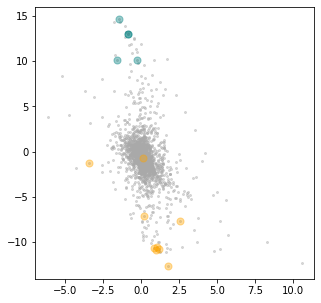

In [62]:
x = fc_par[:,0]
y = -(fc_par[:,1]+fc_par[:,2])
fig1,ax1=plt.subplots(1,1,figsize=(5,5))   
ax1.scatter(x,y,4,'darkgray',alpha=0.4)
# ax1.scatter(x[gf_rej],y[gf_rej],4,'darkgray',alpha=0.4)
ax1.scatter(x[gf_mark_t],y[gf_mark_t],50,'orange',alpha=0.4)
ax1.scatter(x[gf_mark_b],y[gf_mark_b],50,'teal',alpha=0.4)
# ax1.scatter(x[gf_mark_mono],y[gf_mark_mono],50,'teal',alpha=0.4)


INFO:root:Figure stored to ./fits/gg_221111_025_pbmc_celltypes_5/analysis_figures/pair_parameter_comparison_12.png.


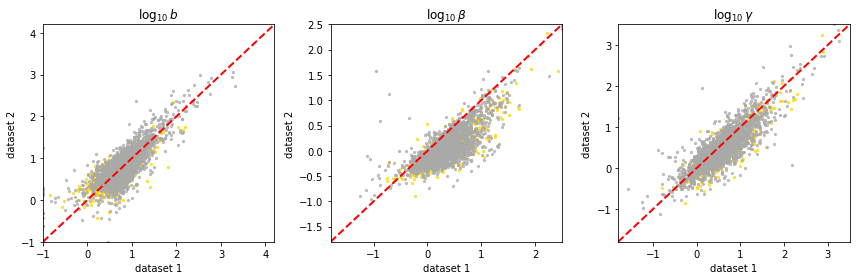

In [116]:
monod.analysis.plot_params_for_pair(sr_arr[3],sr_arr[11])

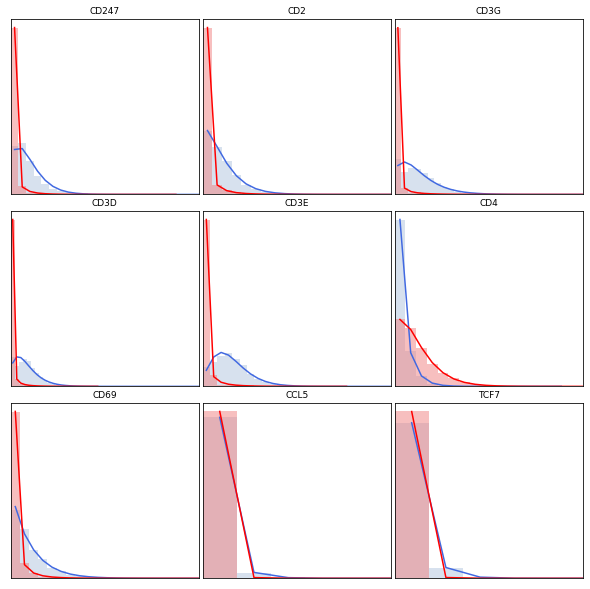

In [45]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_t,sz=(3,3),figsize=(8,8))

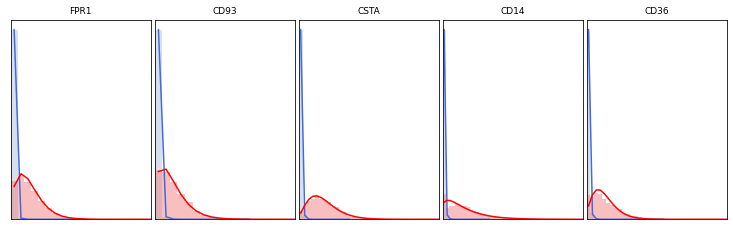

In [46]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_mono,sz=(1,5),figsize=(10,3))

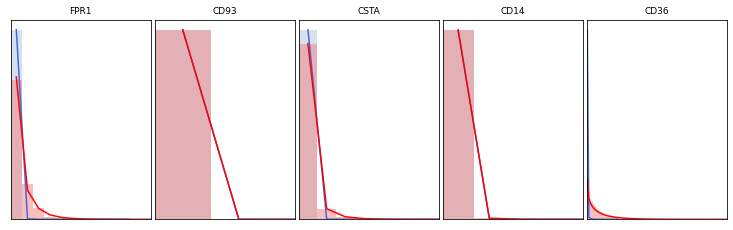

In [47]:
monod.analysis.compare_gene_distributions([sr_arr[3],sr_arr[4]],[sd_arr[3],sd_arr[4]],genes_to_plot=gf_mark_mono,sz=(1,5),figsize=(10,3),marg='nascent')

In [50]:
sr_arr[4].rejected_genes[gf_mark_mono]

array([ True,  True, False,  True,  True])

In [51]:
sr_arr[3].rejected_genes[gf_mark_mono]

array([ True,  True,  True, False,  True])

In [84]:
sr_arr[4].pval

array([8.99415859e-02, 8.50669148e-10, 1.45466440e-01, ...,
       1.43630753e-05, 7.82397709e-49, 6.85224801e-17])

In [83]:
sr_arr[3].phys_optimum[gf_mark_mono]

array([[-1.        ,  0.68386057,  0.40536765],
       [-1.        ,  2.43534984,  0.05366191],
       [-1.        ,  0.66731879, -0.12302229],
       [ 0.01687892,  0.41421333,  0.77973229],
       [ 0.0460508 ,  1.28807305,  0.74510595]])

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/10x_pbmc_10k_Monocytes/Bursty_Poisson_20x21/analysis_figures/gene_distributions_nascent.png.


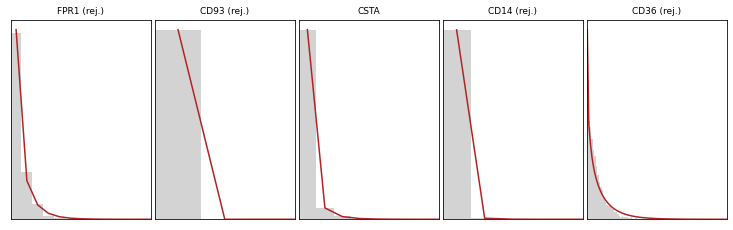

In [52]:
sr_arr[4].plot_gene_distributions(sd_arr[4],sz=(1,5),figsize=(10,3),marg='nascent',genes_to_plot=gf_mark_mono)

INFO:root:Figure stored to ./fits/gg_221108_025_pbmc_celltypes_3/10x_pbmc_10k_Monocytes/Bursty_Poisson_20x21/analysis_figures/gene_distributions_mature.png.


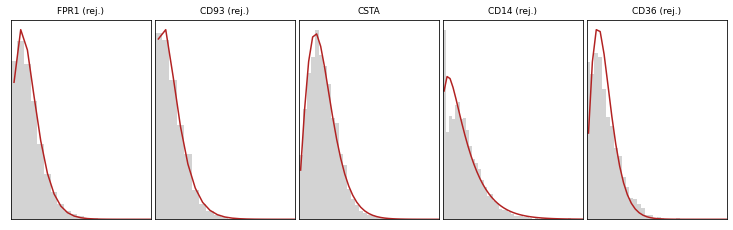

In [53]:
sr_arr[4].plot_gene_distributions(sd_arr[4],sz=(1,5),figsize=(10,3),marg='mature',genes_to_plot=gf_mark_mono)